# GTI771 - Apprentissage machine avancé
## Département de génie logiciel et des technologies de l’information


## Laboratoire 3 - Extraction de primitives « deep »
#### <font color=black> Version 2 - Été 2024 </font>

##### <font color=grey> Version 1 - Prof. Alessandro L. Koerich.
##### Version 2 - Chargé de lab. Arthur Josi

| NOMS                  | CODE PERMANENT                                   |
|-----------------------|--------------------------------------------------|
| Étudiant1             | Code1                                            |
| Étudiant2             | Code2                                            |
| Étudiant3             | Code3                                            |

## Introduction
L'extraction de primitives est un des éléments clés des nombreux pipelines pour l'apprentissage automatique. De nombreuses méthodes reposent sur des algorithmes d'extraction de caractéristiques conçues par les humains comme SIFT, SURF, ORB, ou les descripteurs LBP, LPQ, HOG, etc.

Cependant, depuis l'avènement des architectures de réseaux neuronaux convolutifs (CNNs), les CNN sont devenus l'épine dorsale des pipelines de traitement d'images pour une grande variété d'applications, de la classification d'images à la détection, du suivi à la localisation et la reconnaissance d'objets.

Dans ce laboratoire, nous allons explorer les performances des CNNs préentraînés lorsqu'ils sont réutilisés comme extracteurs de primitives pour le problème de classification des émotions. Pour ce faire, nous allons examiner les caractéristiques extraites de différentes couches de différents CNNs entraînés avec ImageNet.

L’évaluation de ce laboratoire sera basée sur:
- l'utilisation correcte des CNNs préentraînés;
- la qualité des algorithmes proposés et utilisés;
- les réponses aux questions dans ce notebook;
- l'organisation de votre code source (SVP, n'oubliez pas de mettre des commentaires dans le code source!)

# Modules et bibliotèques python

###  <font color=blue> À faire: </font>
1. Ajouter les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

### Import de bibliotèques

In [4]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library

2. Ajouter toutes vos fonctions dans la cellule suivante avec une description de celles-ci.

### Définition des fonctions

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
from matplotlib.cbook import flatten
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io


def fa():
    return 1

############################################# Standardizer #############################################

def normalize(X) -> np.ndarray:
    return X / 255.0

def standardize(data: np.ndarray) -> np.ndarray:
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)
    return data_standardized, scaler

def min_max_scale(data: np.ndarray) -> np.ndarray:
    min_max_scaler = MinMaxScaler(feature_range=(0, 255))
    data_scaled = min_max_scaler.fit_transform(data)
    return data_scaled, min_max_scaler

def processData(Xtrain, Xtest, Xval, is4848:bool = True):
    # Normalize the data
    #print("Normalized Data:")
    #print(Xtrain[0], Xtest[0], Xval[0])
    # Flatten the images
    Xtrain_flattened = Xtrain.reshape((Xtrain.shape[0], -1))
    Xtest_flattened = Xtest.reshape((Xtest.shape[0], -1))
    Xval_flattened = Xval.reshape((Xval.shape[0], -1))

  # Standardize
    Xtrain_standardized, standardizer = standardize(Xtrain_flattened)
    Xtest_standardized = standardizer.transform(Xtest_flattened)
    Xval_standardized = standardizer.transform(Xval_flattened)

    # Min-Max Scale
    Xtrain_scaled, minMaxScaler = min_max_scale(Xtrain_standardized)
    Xtest_scaled = minMaxScaler.transform(Xtest_standardized)
    Xval_scaled = minMaxScaler.transform(Xval_standardized)

    # Reshape back to original image shape
    if is4848:
        Xtrain_processed = Xtrain_scaled.reshape( Xtrain.shape[0], 1, 48, 48 )
        Xtest_processed  = Xtest_scaled.reshape( Xtest.shape[0], 1, 48, 48 )
        Xval_processed   = Xval_scaled.reshape( Xval.shape[0], 1, 48, 48 )
    else:
        Xtrain_processed = Xtrain_scaled.reshape( Xtrain.shape[0], -1)
        Xtest_processed  = Xtest_scaled.reshape( Xtest.shape[0],-1 )
        Xval_processed   = Xval_scaled.reshape( Xval.shape[0],-1 )
    #print("Processed Data:")
    #print(Xtrain_processed[0], Xtest_processed[0], Xval_processed[0])

    return Xtrain_processed, Xtest_processed, Xval_processed



def apply3channelNomralisation(data:np.ndarray) -> np.ndarray:

    list_features = []
    list_pil = []
    images_return = []
    i = 0

    #print(data.shape)
    #print(len(data))
    
    for images in data:
        i+=1
        if(i % 1000 == 0):
            print("progress: ", i/ len(data) * 100, "%")

        image_array, _pil = preprocess_grayscale_image(images.reshape(48, 48))

        #print(image_array.shape)
        images = image_array.flatten()
        images = images.reshape(1, 224, 224, 3)
        features = extract_features(images)
        list_features.append(features)
        list_pil.append(_pil)
        images_return.append(images)
        #print(images.shape)

    data = np.array(images_return).reshape(len(data), 224, 224,3)
    
    return data, list_pil, list_features


# Partie 1 - Ensemble de données

Point de départ: *fer2013-clean.csv* ou *fer2013-clean-pre.csv*

## 1a: Charger le fichier de données nettoyé et normalisé

###  <font color=blue> À faire: </font>
1. Reprenez votre ensemble de données nettoyé et repérez les trois partitions de données: apprentissage, validation et test.

In [7]:
# Load data - Au choix:

# ferData = np.loadtxt( 'fer2013-clean.csv', delimiter=',', dtype=str )
ferData = np.loadtxt( 'content/fer2013-clean-pre.csv', delimiter=',', dtype=str )

training_data = ferData[ferData[:, 2] == 'Training']
validation_data = ferData[ferData[:, 2] == 'PublicTest']
test_data = ferData[ferData[:, 2] == 'PrivateTest']

def transform_str_float(d):
    return np.array([np.fromstring(row, sep=' ', dtype=float) for row in d])

# Training set
Xtrain = transform_str_float(training_data[:, 1])
ytrain = np.array(training_data[:,0], dtype=np.float32)

# Validation set
Xval = transform_str_float(validation_data[:, 1])
yval = np.array(validation_data[:,0], dtype=np.float32)

# # Test set
Xtest = transform_str_float(test_data[:, 1])
ytest = np.array(test_data[:,0], dtype=np.float32)

print(Xtrain.shape, Xval.shape, Xtest.shape)

(28657, 2304) (3582, 2304) (3580, 2304)


In [8]:
# reshape to be [samples][channels][width][height]
Xtrain = Xtrain.reshape( Xtrain.shape[0], 1, 48, 48 ).astype('uint8')
Xtest  = Xtest.reshape( Xtest.shape[0], 1, 48, 48 ).astype('uint8')
Xval   = Xval.reshape( Xval.shape[0], 1, 48, 48 ).astype('uint8')

print( Xtrain.shape, Xval.shape, Xtest.shape )

Xtrain_processed, Xtest_processed, Xval_processed = processData(Xtrain, Xtest, Xval)

(28657, 1, 48, 48) (3582, 1, 48, 48) (3580, 1, 48, 48)


# Partie 2: Extraction de primitives « deep »

Nous pouvons utiliser des réseaux de neurones convolutionnels (CNN) préentraînés comme extracteurs de caractéristiques. Voir cette [référence](https://www.cim.mcgill.ca/~mrl/pubs/ahollid/crv_2020.pdf) ("Pre-trained CNNs as Visual Feature Extractors: A Broad Evaluation") pour vous aider à mieux comprendre quels types de couches peuvent fournir des vecteurs et pour guider le développement de ce TP.

###  <font color=blue> À faire: </font>
1. Choisir une des architectures [CNNs préentraînés disponible dans Keras](https://keras.io/api/applications/) pour l'utiliser comme un extracteur de primitives à boite fermé. Vous pouvez aussi bien utiliser [PyTorch](https://pytorch.org/vision/main/models) loader et travailler avec les modèles, selon vos préférences. <font color=red> VGG16 interdite! </font>

- <font color=red> Attention! Les équipes doivent utiliser des architectures (modèles) différentes!</font>
- <font color=red> Chaque équipe doit poster un message dans le "forum TP3" avec son choix</font>
-  <font color=red> Premier arrivé, premier servi! </font><br>

2. Étudiez l'architecture choisie pour bien comprendre ses différentes couches et les contraintes pour les images d'entrée. Chaque architecture a ses propres contraintes. Il est alors conseillé de lire attentivement la documentation de l'architecture choisie pour respecter aux exigences du CNN, et cela surtout concernant le format de l'image d'entrée.
- résolution des images d'entrée - Les CNNs ont été entraînés avec une certaine résolution. Vous devrez probabnlement redimensionner vos images de visages;
- nombre de canaux - Les CNNs exigent une image RGB couleur à l'entrée et que vous avez des données en niveaux de gris. Vous devrez répliquer l'image pour avoir 3 canaux.
- normalisation des pixels - Les CNNs peuvent exiger différentes plages de valeurs \[0,1\], \[-1,1\], \[0,255\], etc. <br><br>

3. Choisir les couches à partir desquelles vous souhaitez extraire vos vecteurs de primitive. Vous devez tester/évaluer au moins deux (2) couches différentes pour répondre à cette question.  Générer des vecteurs de primitives « deep » pour l'ensemble de données FER (apprentissage, validation et test).
- N’oubliez pas de normaliser les vecteurs de primitives (p. ex. \[0,1\]). <br><br>

4. Utiliser [T-SNE](https://learnopencv.com/t-sne-for-feature-visualization/) ou [UMAP](https://umap-learn.readthedocs.io/en/latest/plotting.html) comme outils de visualisation afin de determiner la qualité des vecteurs de primitives obtenus via l'une, puis l'autre des couches du CNN utilisé. Penser a afficher chaque classe d'une couleur différente, et utiliser une dimension de 2 (n_components = 2). Comparer les résultats obtenu selon la couche de CNN utilisée.

5. Utiliser l'algorithme choisi dans la question précédente pour visualisez les vecteurs de primitives obtenu dans le laboratoire 2 et commenter.

6. Sauvegardez vos vecteurs de primitives sous la forme d'un fichier 'csv' (p. ex. *fer2013-clean-deepVGG19.csv* ou *fer2013-clean-pre-deepVGG19.csv*). N'oubliez pas d'utiliser toujours la même structure du fichier original *fer2013.csv*. Vous devez nommer vos fichiers de primitive « deep » en référence au CNN utilisé, p. ex., *fer2013-clean-deepVGG19.csv* si vous utilisez VGG19 comme CNN.

7. Décrivez brièvement l'architecture du CNN choisi (nombre et type de couches, etc.), contraintes pour utiliser le modèle pré-entraîné (format image, normalisation, etc.), couches évaluées comme sorties de primitives, et les vecteurs de primitives (dimension, type de variable, etc.)


#### Réponse

Vos réponses écrites ici.

#### Definition des fonctions de conversion

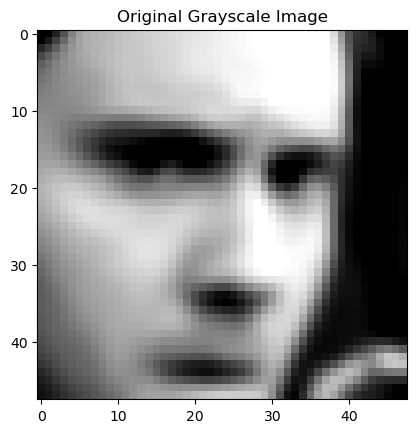

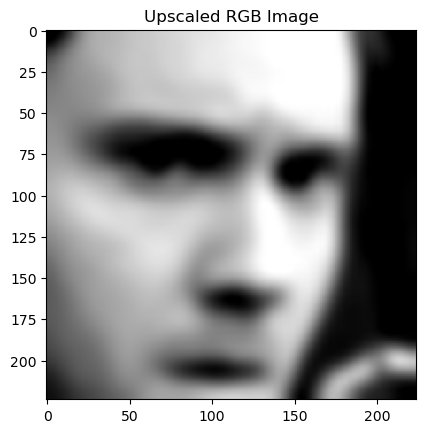

(1, 224, 224, 3)


In [9]:
import cv2
from PIL import Image
import numpy as np
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import matplotlib.pyplot as plt

def preprocess_grayscale_image(image_preprocess):
    """
    Load a 48x48 grayscale image, upscale it to 224x224, convert it to RGB, and preprocess for ResNet50V2.
    
    Parameters:
    - image_preprocess: np.array, 48x48 grayscale image array.

    Returns:
    - image_array: np.array, preprocessed image array ready for ResNet50V2.
    - image_pil: PIL Image, the upscaled RGB image for visualization.
    """
    # Ensure the image is in numpy array format
    if isinstance(image_preprocess, Image.Image):
        image_preprocess = np.array(image_preprocess)
    
    # Upscale the image to 224x224 pixels using cv2
    image_upscaled = cv2.resize(image_preprocess, (224, 224), interpolation=cv2.INTER_CUBIC)
    
    # Convert the upscaled grayscale image to RGB by replicating the grayscale channel
    image_rgb = np.stack((image_upscaled,)*3, axis=-1)
    
    # Convert to uint8
    image_rgb = image_rgb.astype(np.uint8)
    
    # Convert the image to a PIL Image for visualization purposes (optional)
    image_pil = Image.fromarray(image_rgb)
    
    # Preprocess the image array for ResNet50V2
    image_array = preprocess_input(image_rgb)
    
    # Expand dimensions to create a batch of size 1
    image_array = np.expand_dims(image_array, axis=0)
    
    return image_array, image_pil

# Example grayscale image array from Xtrain
image = Xtrain[0].reshape(48, 48)

# Plot the original grayscale image
plt.imshow(image, cmap='gray')
plt.title('Original Grayscale Image')
plt.show()

# Preprocess the image
image_array, image_pil = preprocess_grayscale_image(image)

# Plot the upscaled RGB image
plt.imshow(image_pil)
plt.title('Upscaled RGB Image')
plt.show()

print(image_array.shape)


#### Code

In [10]:
# Votre code ici
import cv2
from PIL import Image
from matplotlib.cbook import flatten
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import skimage.io
import sklearn.datasets
import pandas as pd

def extract_features(image_array):
  
    # Create a new model that outputs the features from the desired layer
    # Get the features
    features = model.predict(image_array, verbose=0)
    #print(features.shape)
    
    return features



print(image_array.shape)
print(image_array.flatten())


# Load ResNet50V2 model without the top layer (include_top=False)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Choose the layer from which to extract features
layer_name = 'conv4_block3_1_conv'

# Get the output tensor of the selected layer
output_tensor = base_model.get_layer(layer_name).output

# Apply global average pooling to reduce dimensionality
pooled_output = GlobalAveragePooling2D()(output_tensor)

# Build a model that outputs the pooled feature vectors
model = Model(inputs=base_model.input, outputs=pooled_output)



print("Start")
print(Xtrain_processed[0].shape)

Xtrain_processed3Channel, train_list_pil, x_train_features = apply3channelNomralisation(Xtrain_processed[:1000])
print("Done 1")
print(Xtrain_processed3Channel[0].shape)

Xtest_processed3Channel, test_list_pil, x_tes_features = apply3channelNomralisation(Xtest_processed[:100])
Xval_processed3Channel, val_list_pil , x_val_features = apply3channelNomralisation(Xval_processed[:100])

(1, 224, 224, 3)
[-1. -1. -1. ... -1. -1. -1.]
Start
(1, 48, 48)
progress:  100.0 %
Done 1
(224, 224, 3)


#### Feature extraction


In [ ]:

import cv2
import numpy as np
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define the feature extraction function
def extract_features(image_array, model):
    features = model.predict(image_array, verbose=0)
    return features

# Load ResNet50V2 model without the top layer (include_top=False)
base_model = ResNet50V2(weights='imagenet', include_top=False, classes=7, input_shape=(224, 224, 3))

# Function to build feature extraction model for a given layer name
def build_feature_extraction_model(layer_name):
    output_tensor = base_model.get_layer(layer_name).output
    pooled_output = GlobalAveragePooling2D()(output_tensor)
    #model = Model(inputs=base_model.input, outputs=pooled_output)
    model = Model(inputs=base_model.input, outputs=output_tensor)

    return model

# Example layers to test
layer_names = ['conv1_conv', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']

# Example image processing function (replace with actual images)

# Example usage
Xtrain_processed3Channel = Xtrain_processed3Channel[:500]
Xtrain_processed = Xtrain_processed[:500]
y_train = ytrain[:500]





In [ ]:
for layer_name in layer_names:
    feature_extraction_model = build_feature_extraction_model(layer_name)
    x_train_features = extract_features(Xtrain_processed3Channel, feature_extraction_model)
    
    print(x_train_features.shape)
    # Flatten the features to use them in t-SNE
    x_train_features_flat = x_train_features.reshape((x_train_features.shape[0], -1))

    print(x_train_features_flat.shape)
    
    # Visualize features using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    x_train_features_2d = tsne.fit_transform(x_train_features_flat)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_train_features_2d[:, 0], x_train_features_2d[:, 1], c=y_train, cmap='viridis')
    plt.title(f'Features extracted from layer: {layer_name}')
    plt.colorbar(scatter, ticks=range(7), label='Classes')
    plt.show()

print(model.summary())


# Partie 3: Entraînement de modèles d'apprentissage machine

Vous êtes maintenant prêt à entraîner un modèle d'apprentissage automatique avec les vecteurs de primitives « deep » extraits dans la Partie 2. Nous allons de nouveau utiliser un arbre de décision, comme dans le lab précédent.

## 3a: Entraîner un arbre de décision avec les primitives « deep »

###  <font color=blue> À faire: </font>

1. Utiliser l'algorithme [arbre de décision](https://scikit-learn.org/stable/modules/tree.html#tree-classification) de la bibliothèque `scikit-learn` après l'étude de [ses hyperparamètres](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). Choisir quelques hyperparamètres (au moins 2) et tourner un *grid search* sur l'ensemble de validation pour trouver les meilleures valeurs pour ces hyperparamètres.
   - Astuce: Vous avez déjà un ensemble de validation! Alors, c'est préférable (beaucoup plus rapide!) d’utiliser la bibliothèque [hypopt](https://pypi.org/project/hypopt/) pour faire le réglage des hyperparamètres (grid seach)<br><br>

2. Une fois que vous avez trouvé le meilleur modèle, utiliser ces modèles pour faire la prédiction sur tous les exemples (apprentissage, validation, test) et rapporter les résultats (comme fait dans les TP1 et TP2):<br>
   4a. Rapport de classification produit avec *<font color=green>from sklearn.metrics import classification_report</font>*<br>
   4b. taux de classification correct sur les trois (3) ensembles de données (sous la forme d'un tableau)<br>
   4c. matrice de confusion produite avec *<font color=green> from sklearn.metrics import confusion_matrix</font>* pour les résultats sur l'ensemble de test (matrice 7 $\times$ 7 - étiquéttes $\times$ prédictions)

5. Sauvegarder votre modèle dans un fichier *.pkl*. Regarder [model persistence](https://scikit-learn.org/stable/model_persistence.html)

6. Comparez les résultats avec ceux attendus avec les primitives globales/locales (TP2) et *template matching* (TP1)

7. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur la performance de vos primitives « deep ».

**Question bonus (Tout élément de réponse pourra vous apporter des points bonus):**

Utiliser un modèle tel qu'un [Visual Transformer (ViT)](https://pytorch.org/vision/main/models/vision_transformer.html) ou un [VMamba](https://github.com/MzeroMiko/VMamba) pour extraire les vecteurs de caractéristiques, puis comparer les résultats obtenus après classification via arbre de décision.

#### Code

In [ ]:
# Votre code ici

#### Vos réponses et résultats ici:

##### Exemple:

Taux de classification correcte (%)

| Ensemble | modèle TM   |  AD+LBP Global  | AD+LBP Local  | modèle deep 1 | modèle deep 2 |                                   
|----------|-------------|-----------------|---------------|---------------|---------------|
| App      | 99,67       |                 |               |               |               |                   
| Val      | 89,77       |                 |               |               |               |                             
| Test     | 77,99       |                 |               |               |               |

# Fin